In [1]:
import numpy as np
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [2]:
psi = np.load('/home/fabio/work/HM_and_AI_models/VAE_Model/data/long_run_310k.npy')

psi = psi[:, 0, :]
print(psi.shape)

psi_val= psi[210000:270000, :]
psi = psi[0:300000, :]

print(psi_val.shape)
print(psi.shape)

(309700, 75)
(60000, 75)
(300000, 75)


In [3]:
# Pre-processing


num_of_prev_t = 200
lead = 1

trainN = 200000
valN = 50000
index = 63


mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi


#Training Data
psi_train_input = torch.tensor(psi[num_of_prev_t : trainN + num_of_prev_t,:]) #Has to increase by n-time steps more than memory size 
psi_train_label =  torch.tensor(psi[num_of_prev_t + lead : trainN + lead + num_of_prev_t,:])
psi_torch = torch.as_tensor(psi, dtype=torch.float16)
psi_memory = (psi_torch.unfold(dimension=0, size=num_of_prev_t, step=1)[:trainN].reshape(trainN, -1))
print("Train input: ", psi_train_input.shape)
print("Train label: ", psi_train_label.shape)
print("Memory: ", psi_memory.shape)

#Validation Data
# psi_val_input = torch.tensor(psi_val[num_of_prev_t : valN + num_of_prev_t, :])
# psi_val_label =  torch.tensor(psi_val[num_of_prev_t + lead : valN + num_of_prev_t + lead, :])
# psi_val_torch = torch.as_tensor(psi_val, dtype=torch.float32)
# psi_memory_val = (psi_val_torch.unfold(dimension=0, size=num_of_prev_t, step=1)[:valN].reshape(valN, -1))
# print("Train input: ", psi_train_input.shape)
# print("Validation label ", psi_val_label.shape)
# print("Val Memory: ", psi_memory_val.shape)


# #actual implementation
# pred_hist, _ = np.histogram(predictions, bins=50, density=True)
# actual_hist, _ = np.histogram(actual_values,bins=50,density=True)

# tvd = total_variation_distance(pred_hist,actual_hist)


Train input:  torch.Size([200000, 75])
Train label:  torch.Size([200000, 75])
Memory:  torch.Size([200000, 15000])


(300000, 75)


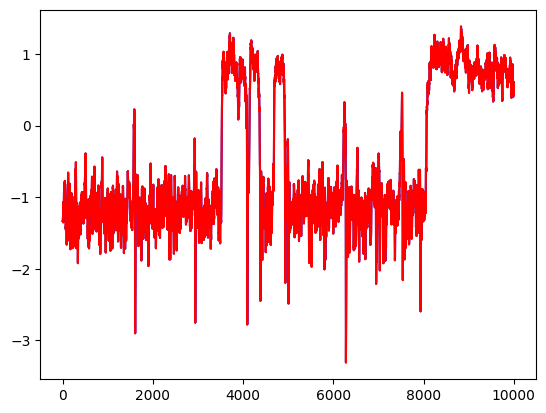

In [4]:
print(psi.shape)
# plt.plot(psi_train_input[0:200000,63])
plt.plot(psi_train_input[0:10000,63], color="blue")
plt.plot(psi_train_label[0:10000, 63], color="red")


In [6]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)  
        self.fc2 = nn.Linear(512, 512)  
        self.fc3 = nn.Linear(512, 512)  
        self.fc4 = nn.Linear(512, 512)  
        self.fc5 = nn.Linear(512, 512)  
        self.fc6 = nn.Linear(512, 512)  
        self.fc_mu = nn.Linear(512, latent_dim)  
        self.fc_logvar = nn.Linear(512, latent_dim)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, prev_elem):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim + prev_elem, 512)  
        self.fc2 = nn.Linear(512, 512) 
        self.fc3 = nn.Linear(512, 512) 
        self.fc4 = nn.Linear(512, 512)         
        self.fc5 = nn.Linear(512, 512)  
        self.fc6 = nn.Linear(512, 512)  
        self.fc_output = nn.Linear(512, output_dim) 

    def forward(self, z, input_val, prev_element):
        """"
        z = latent_space 
        input_val = is the input value in batches
        prev_element = the previous elements
        """
        z = torch.cat((z, input_val), dim=1)  # Concatenate latent vector and condition 
        z = torch.cat((z, prev_element), dim = 1)
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, condition_dim, prev_elem):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim, prev_elem)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
#I need to put the prev_elem (X(t - 1)) in the latent space that is passed to 
#the decoder to recontruct an output (X(t + 1)).
    def decode(self, z, condition, prev_elem):
        return self.decoder(z, condition, prev_elem)

#When model() is called this function is called.
    def forward(self, label_val, input_val, prev_elem):
        mu, logvar = self.encode(label_val)
        latent_space = self.reparameterize(mu, logvar)
        output = self.decode(latent_space, input_val, prev_elem)
        return output, mu, logvar


Epoch 1, 
          Reconstrunction Loss: 6657.18212890625,
          KL Divergence Lwss: 1373.40185546875
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


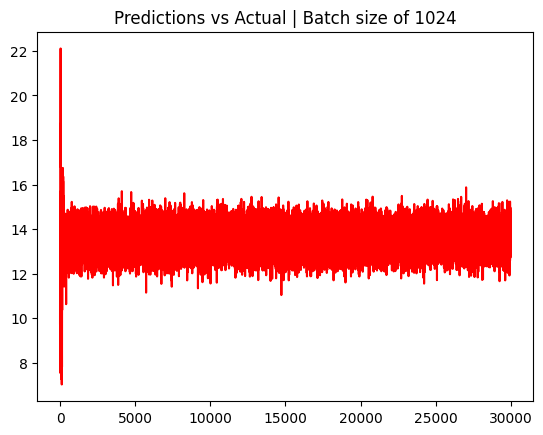

Epoch 2, 
          Reconstrunction Loss: 5159.8984375,
          KL Divergence Lwss: 664.7626342773438
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


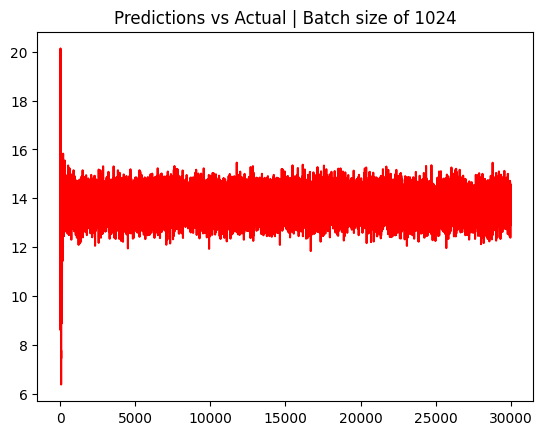

Epoch 3, 
          Reconstrunction Loss: 3850.603515625,
          KL Divergence Lwss: 432.8204040527344
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


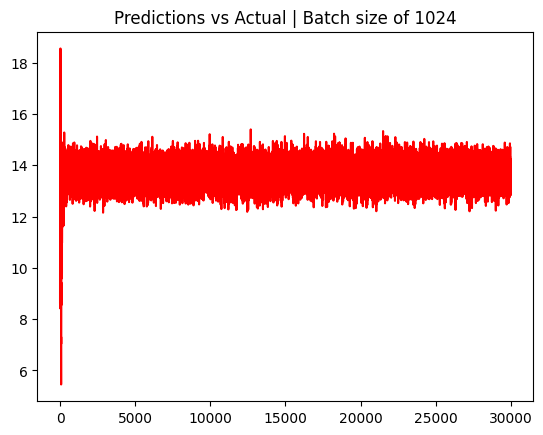

Epoch 4, 
          Reconstrunction Loss: 2761.8154296875,
          KL Divergence Lwss: 315.11480712890625
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


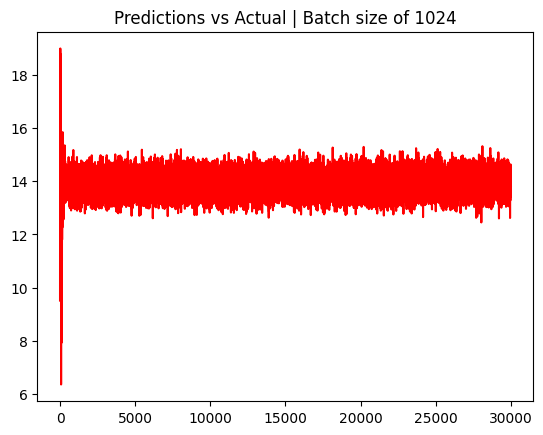

Epoch 5, 
          Reconstrunction Loss: 2427.5830078125,
          KL Divergence Lwss: 243.7421417236328
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


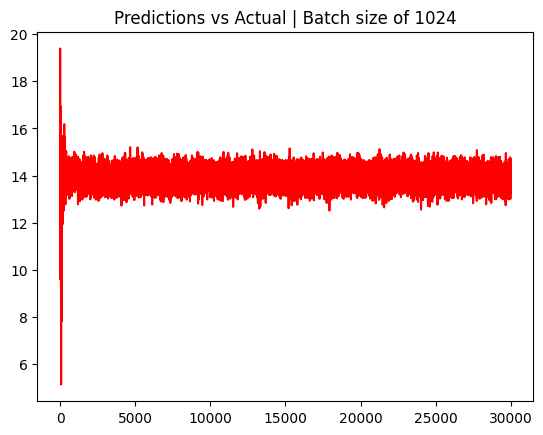

Epoch 6, 
          Reconstrunction Loss: 1932.24560546875,
          KL Divergence Lwss: 195.57943725585938
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


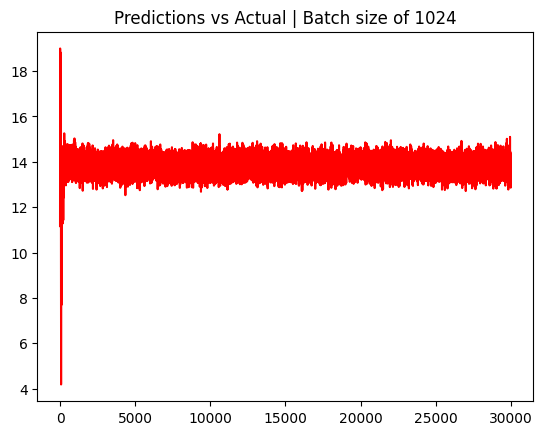

Epoch 7, 
          Reconstrunction Loss: 1893.3564453125,
          KL Divergence Lwss: 160.6699676513672
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


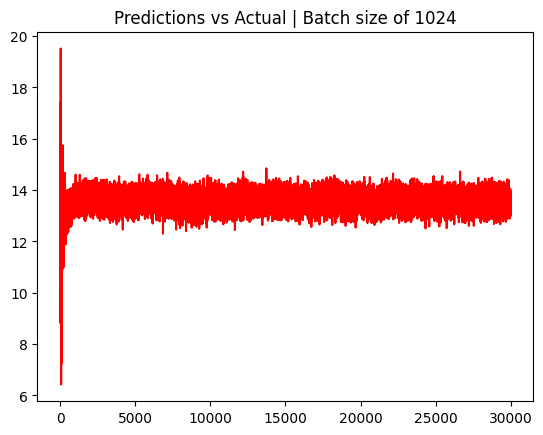

Epoch 8, 
          Reconstrunction Loss: 1586.85205078125,
          KL Divergence Lwss: 134.36993408203125
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


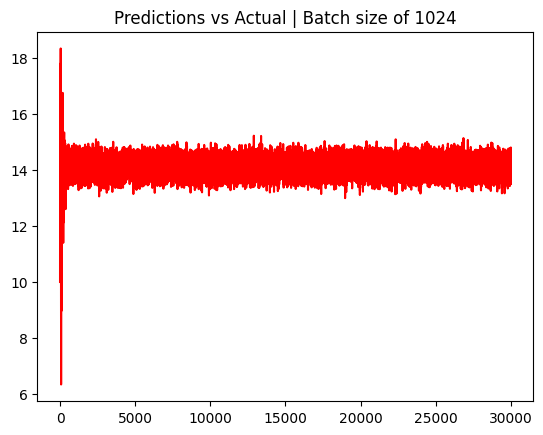

Epoch 9, 
          Reconstrunction Loss: 1564.1094970703125,
          KL Divergence Lwss: 113.65896606445312
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


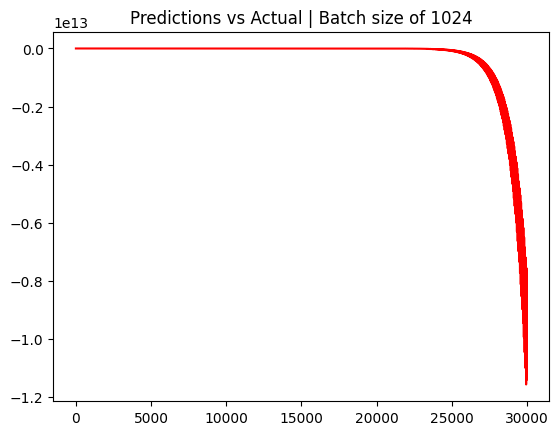

Epoch 10, 
          Reconstrunction Loss: 1773.0697021484375,
          KL Divergence Lwss: 96.99139404296875
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


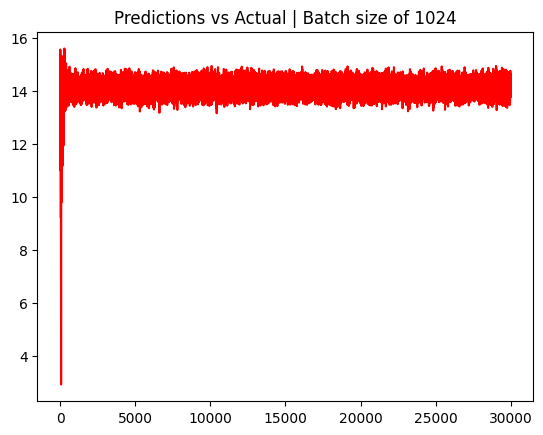

Epoch 11, 
          Reconstrunction Loss: 1202.19921875,
          KL Divergence Lwss: 83.45741271972656
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


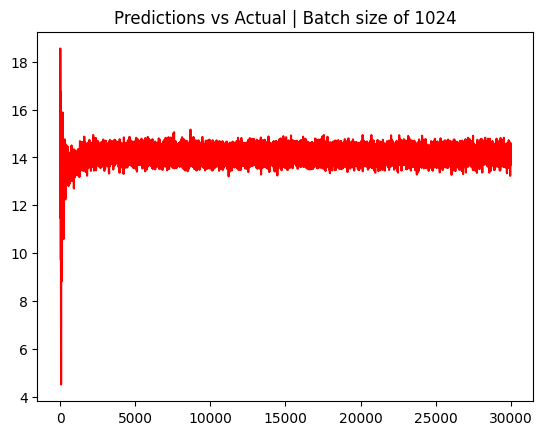

Epoch 12, 
          Reconstrunction Loss: 1047.9796142578125,
          KL Divergence Lwss: 72.46920776367188
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


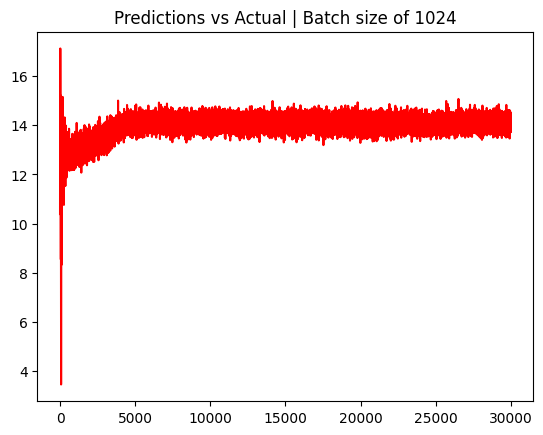

Epoch 13, 
          Reconstrunction Loss: 1142.6484375,
          KL Divergence Lwss: 63.034549713134766
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


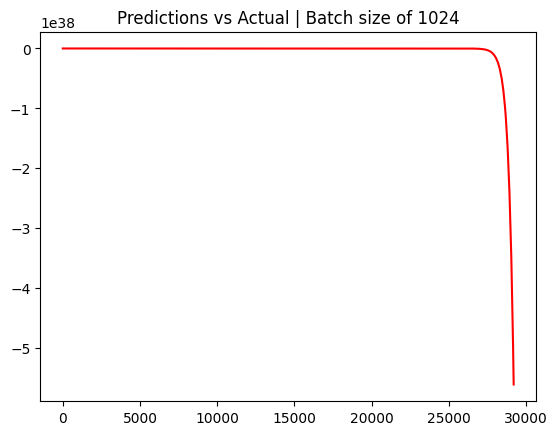

Epoch 14, 
          Reconstrunction Loss: 972.3963623046875,
          KL Divergence Lwss: 55.33079528808594
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


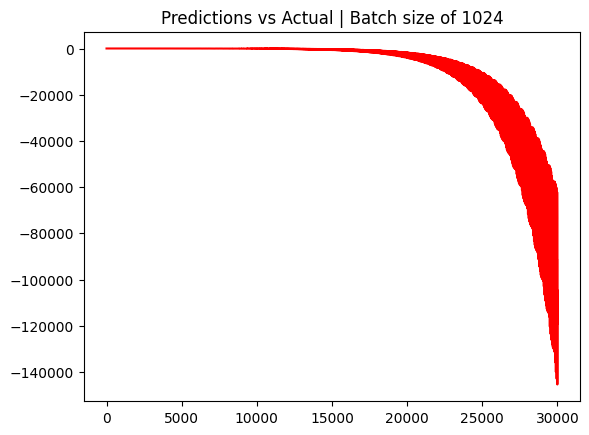

Epoch 15, 
          Reconstrunction Loss: 1053.406494140625,
          KL Divergence Lwss: 47.85505676269531
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


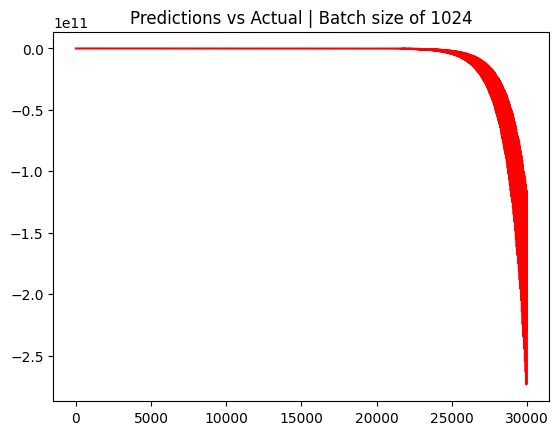

Epoch 16, 
          Reconstrunction Loss: 1140.16455078125,
          KL Divergence Lwss: 42.14702606201172
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


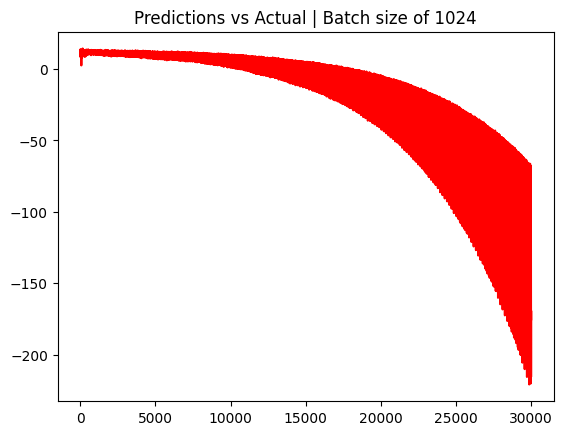

Epoch 17, 
          Reconstrunction Loss: 845.790771484375,
          KL Divergence Lwss: 38.84422302246094
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


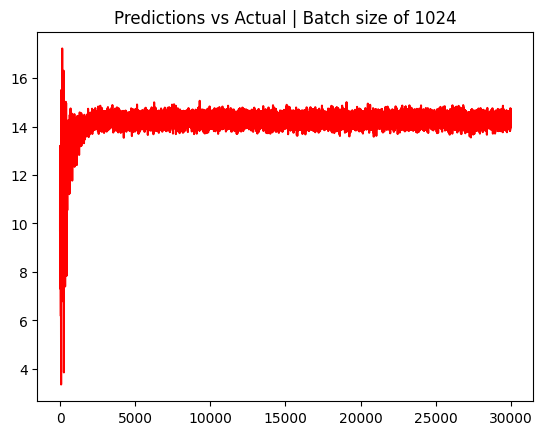

Epoch 18, 
          Reconstrunction Loss: 756.3804931640625,
          KL Divergence Lwss: 31.335533142089844
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


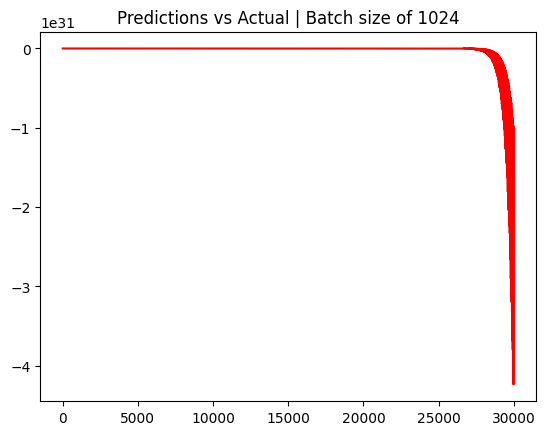

Epoch 19, 
          Reconstrunction Loss: 838.6072998046875,
          KL Divergence Lwss: 31.673492431640625
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


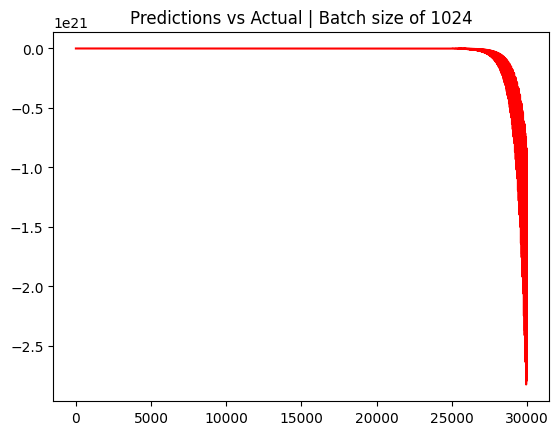

Epoch 20, 
          Reconstrunction Loss: 974.8897705078125,
          KL Divergence Lwss: 23.9195556640625
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


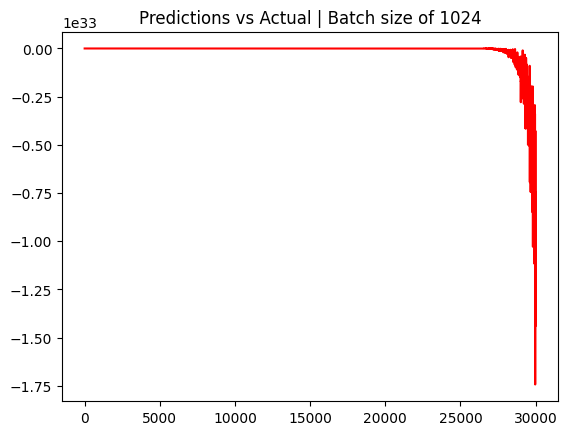

Epoch 21, 
          Reconstrunction Loss: 1037.1768798828125,
          KL Divergence Lwss: 22.061349868774414
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


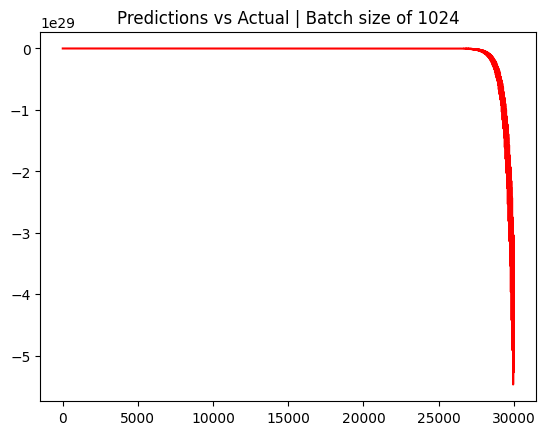

Epoch 22, 
          Reconstrunction Loss: 823.9694213867188,
          KL Divergence Lwss: 18.967355728149414
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


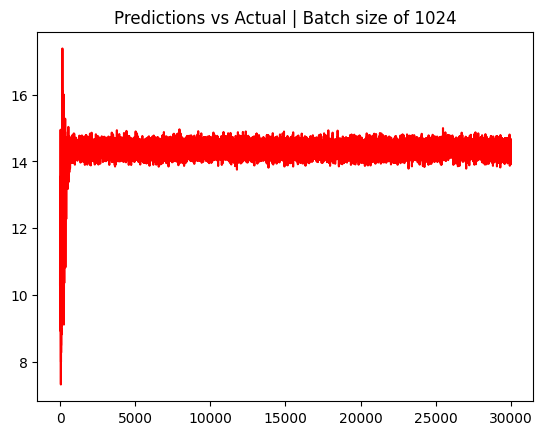

Epoch 23, 
          Reconstrunction Loss: 666.8917846679688,
          KL Divergence Lwss: 20.393590927124023
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


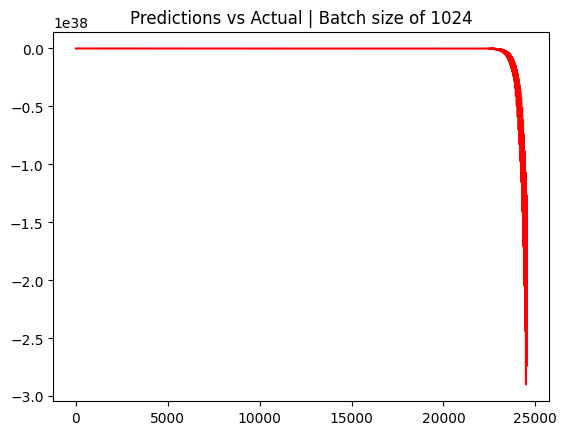

Epoch 24, 
          Reconstrunction Loss: 589.0169067382812,
          KL Divergence Lwss: 14.592927932739258
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


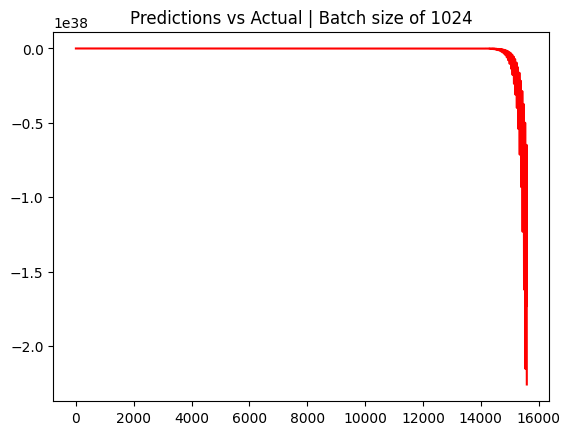

Epoch 25, 
          Reconstrunction Loss: 887.654541015625,
          KL Divergence Lwss: 13.662286758422852
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


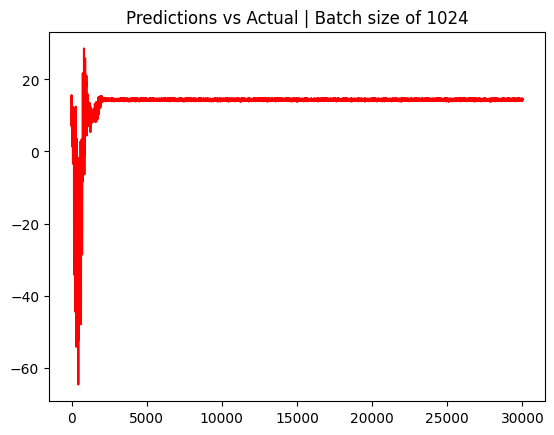

Epoch 26, 
          Reconstrunction Loss: 699.3216552734375,
          KL Divergence Lwss: 16.471893310546875
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


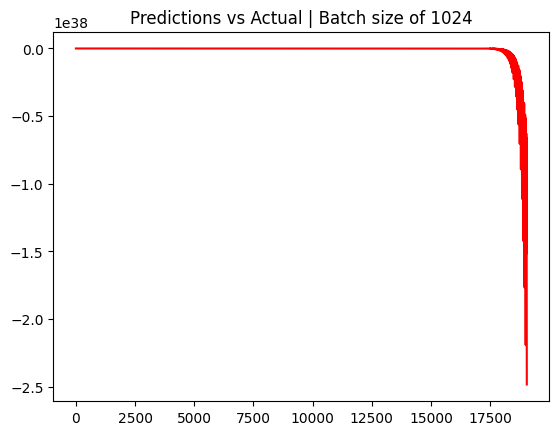

Epoch 27, 
          Reconstrunction Loss: 544.12255859375,
          KL Divergence Lwss: 9.509635925292969
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


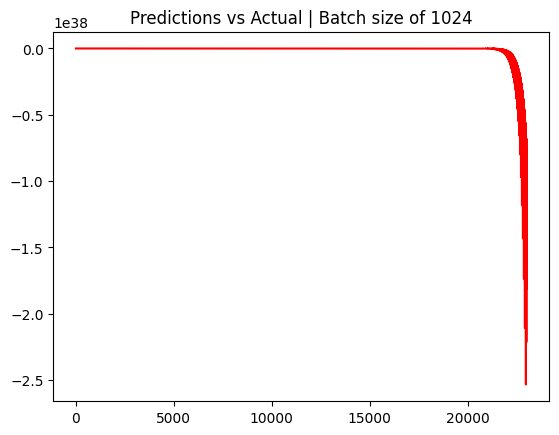

Epoch 28, 
          Reconstrunction Loss: 549.968994140625,
          KL Divergence Lwss: 12.111772537231445
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


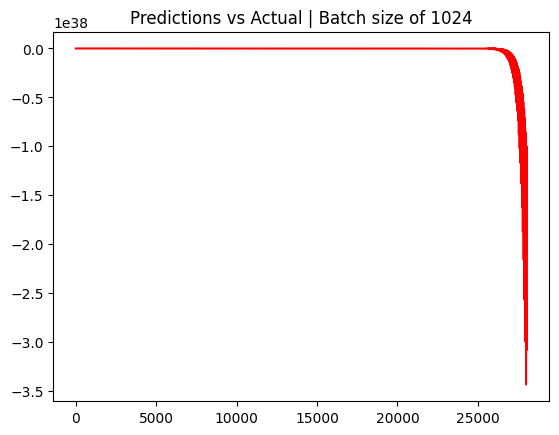

Epoch 29, 
          Reconstrunction Loss: 648.2587890625,
          KL Divergence Lwss: 8.71505355834961
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


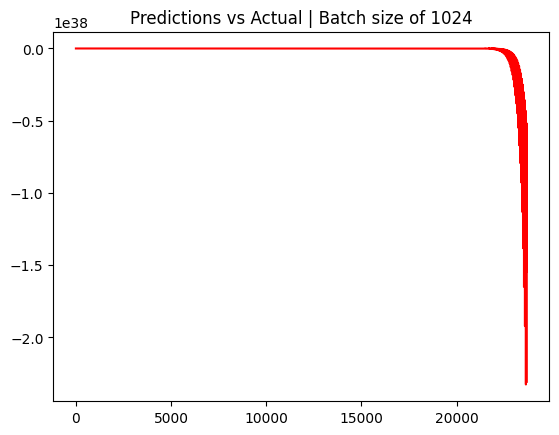

Epoch 30, 
          Reconstrunction Loss: 573.5001220703125,
          KL Divergence Lwss: 7.963978290557861
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


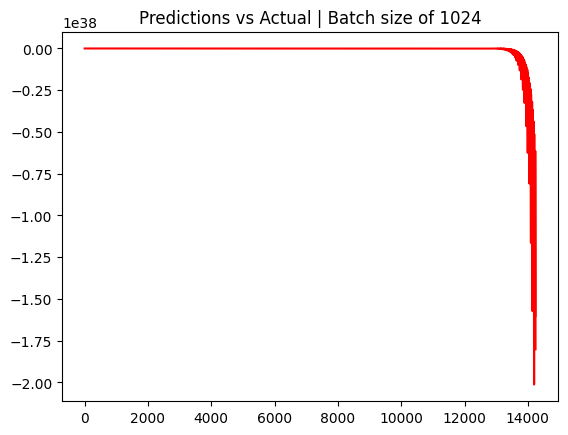

Epoch 31, 
          Reconstrunction Loss: 595.723876953125,
          KL Divergence Lwss: 8.05322265625
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


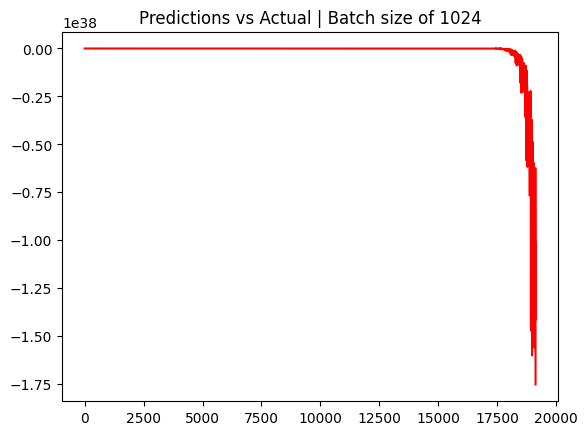

Epoch 32, 
          Reconstrunction Loss: 563.2883911132812,
          KL Divergence Lwss: 7.15769100189209
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


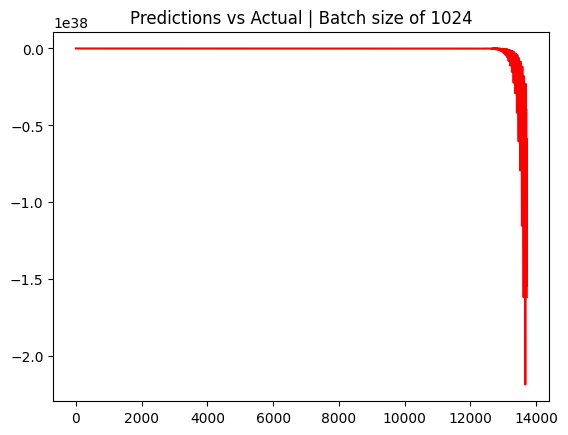

Epoch 33, 
          Reconstrunction Loss: 538.2402954101562,
          KL Divergence Lwss: 8.003188133239746
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


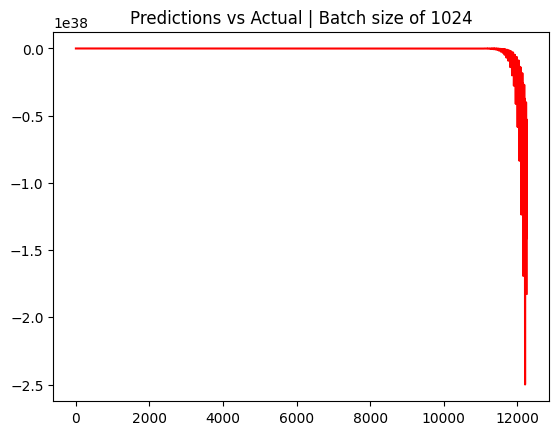

Epoch 34, 
          Reconstrunction Loss: 540.379150390625,
          KL Divergence Lwss: 6.808402061462402
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


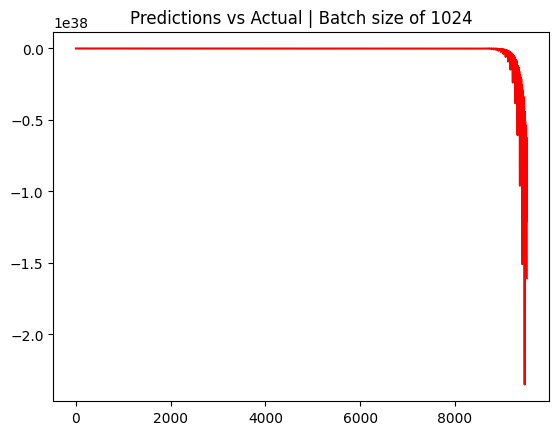

Epoch 35, 
          Reconstrunction Loss: 526.9000244140625,
          KL Divergence Lwss: 5.635561943054199
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


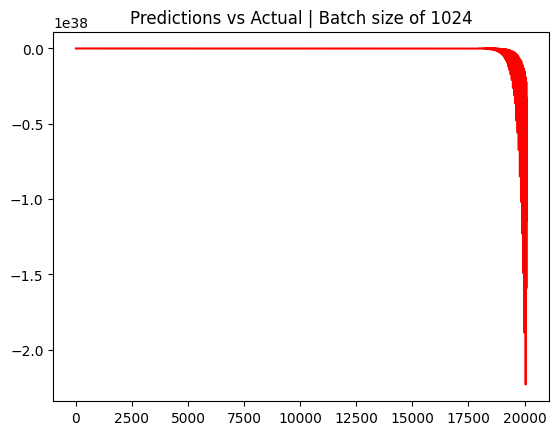

Epoch 36, 
          Reconstrunction Loss: 496.1690673828125,
          KL Divergence Lwss: 6.722285270690918
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


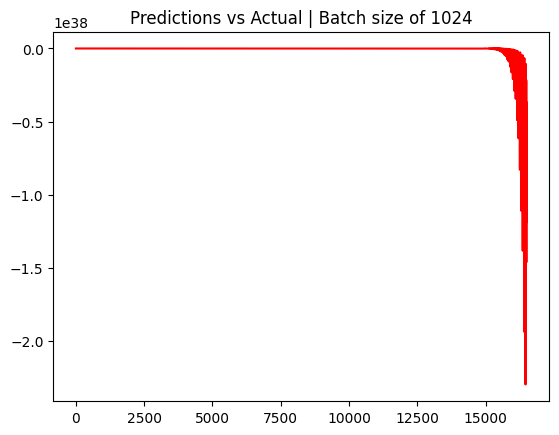

Epoch 37, 
          Reconstrunction Loss: 565.5460205078125,
          KL Divergence Lwss: 5.978666305541992
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


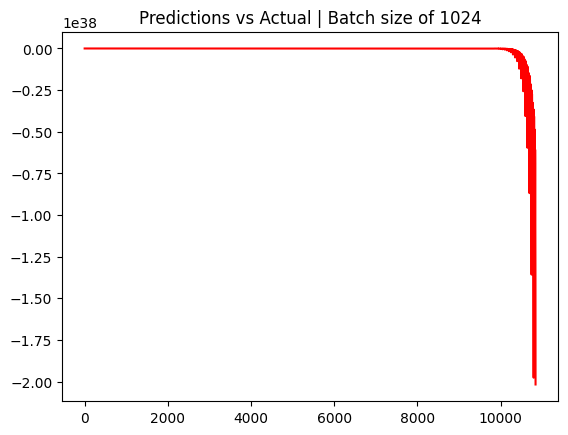

Epoch 38, 
          Reconstrunction Loss: 504.9177551269531,
          KL Divergence Lwss: 4.4824113845825195
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


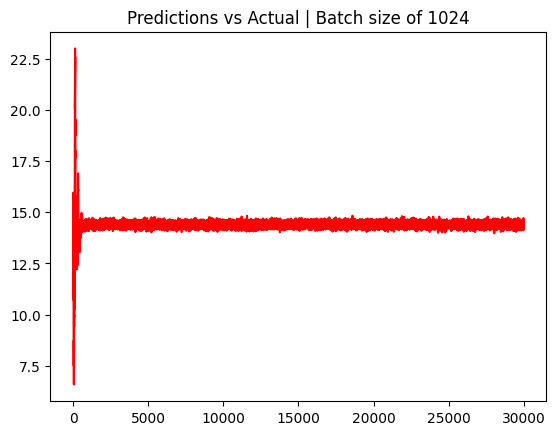

Epoch 39, 
          Reconstrunction Loss: 547.721923828125,
          KL Divergence Lwss: 4.940398216247559
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


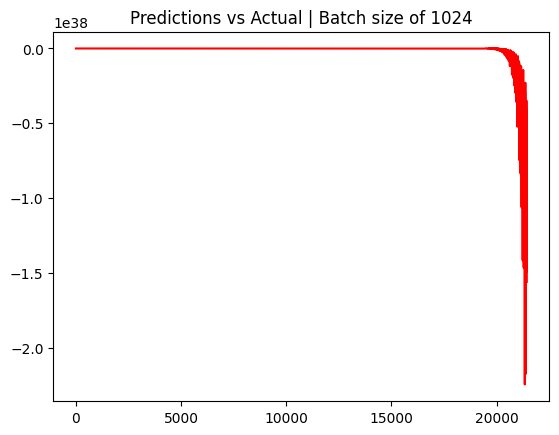

Epoch 40, 
          Reconstrunction Loss: 412.6206970214844,
          KL Divergence Lwss: 5.181840419769287
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


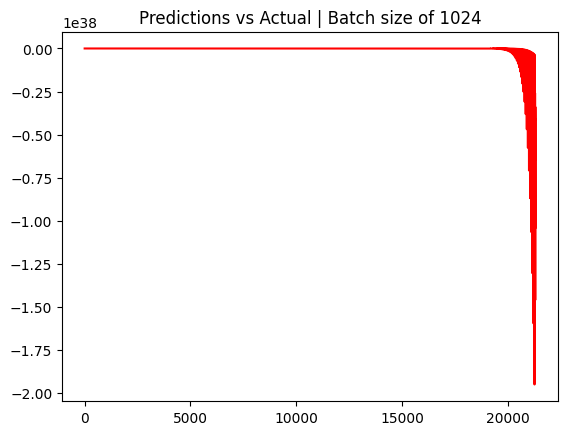

Epoch 41, 
          Reconstrunction Loss: 457.1309814453125,
          KL Divergence Lwss: 3.715693473815918
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


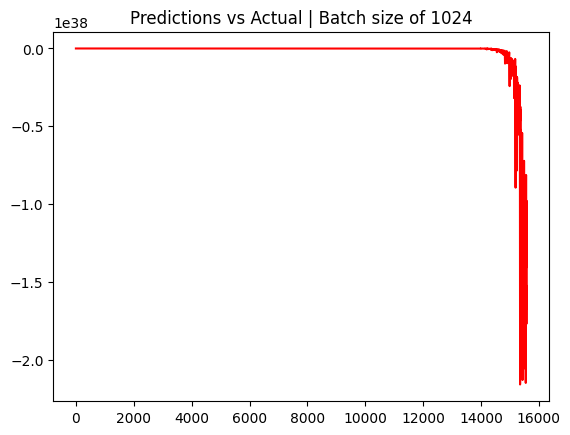

Epoch 42, 
          Reconstrunction Loss: 393.0082702636719,
          KL Divergence Lwss: 4.021618843078613
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


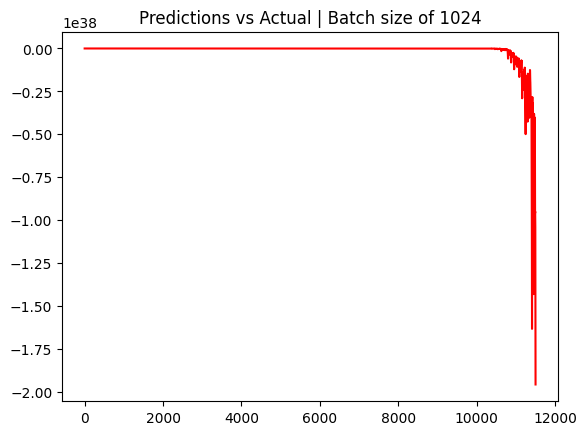

Epoch 43, 
          Reconstrunction Loss: 535.7472534179688,
          KL Divergence Lwss: 4.429154396057129
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


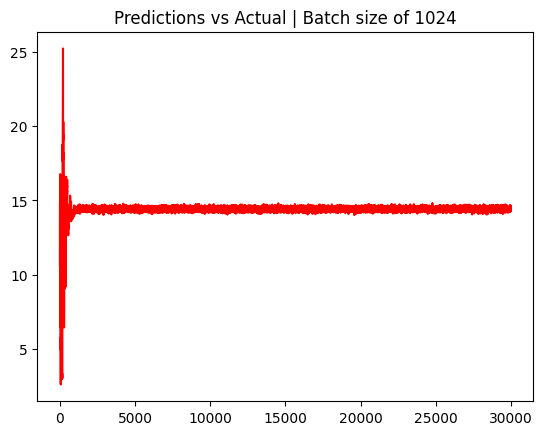

Epoch 44, 
          Reconstrunction Loss: 398.88970947265625,
          KL Divergence Lwss: 3.219923496246338
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


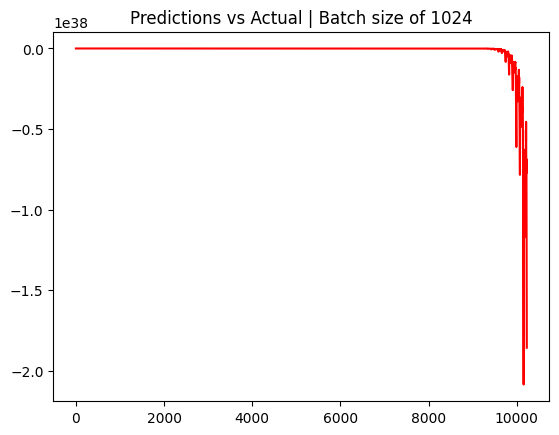

Epoch 45, 
          Reconstrunction Loss: 445.05499267578125,
          KL Divergence Lwss: 3.9889655113220215
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


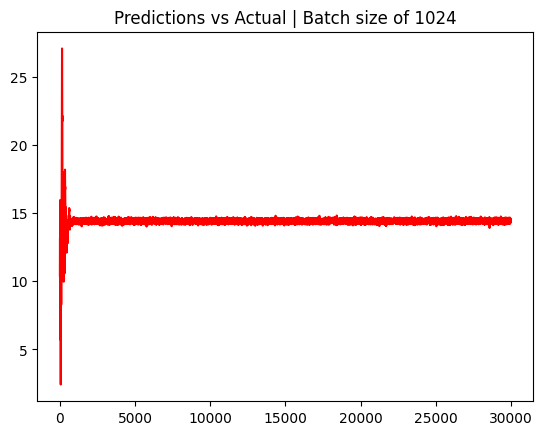

Epoch 46, 
          Reconstrunction Loss: 458.9219970703125,
          KL Divergence Lwss: 3.072453022003174
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


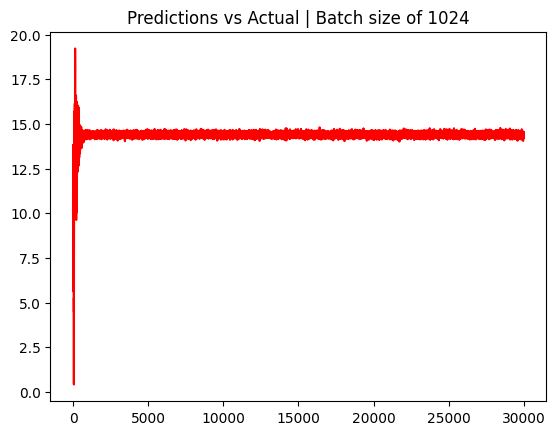

Epoch 47, 
          Reconstrunction Loss: 507.0780029296875,
          KL Divergence Lwss: 3.24375581741333
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


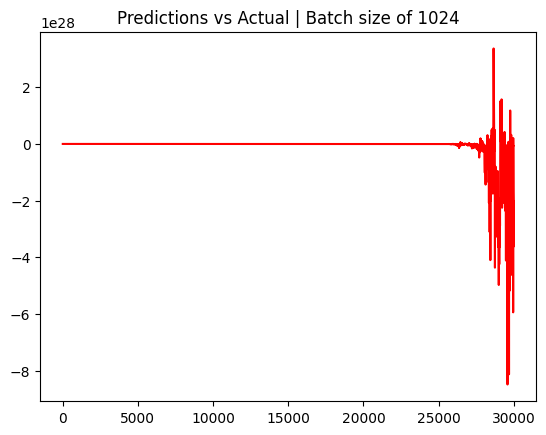

Epoch 48, 
          Reconstrunction Loss: 528.923095703125,
          KL Divergence Lwss: 2.5399036407470703
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


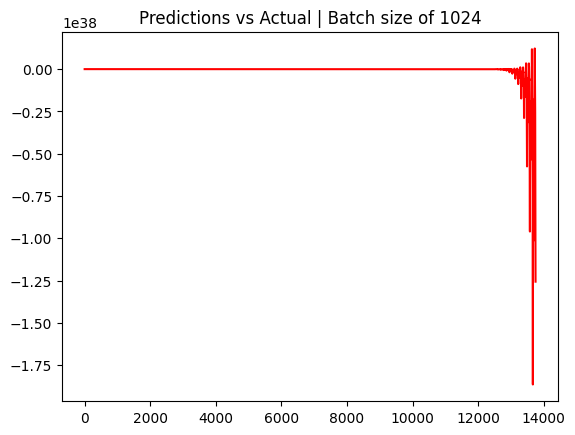

Epoch 49, 
          Reconstrunction Loss: 493.4440612792969,
          KL Divergence Lwss: 4.574232578277588
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


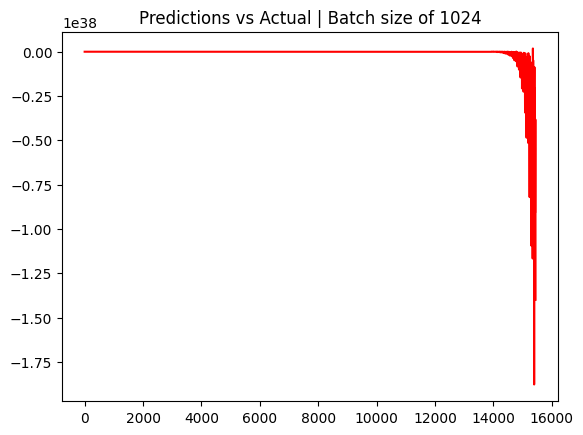

Epoch 50, 
          Reconstrunction Loss: 372.5122375488281,
          KL Divergence Lwss: 3.1877317428588867
[10.48061289]
tensor([ 0.2939,  0.1545,  0.3164,  ..., -1.6293, -0.1631,  0.7068],
       dtype=torch.float64)


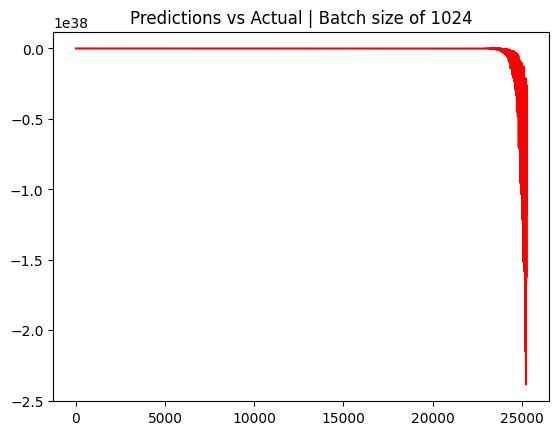

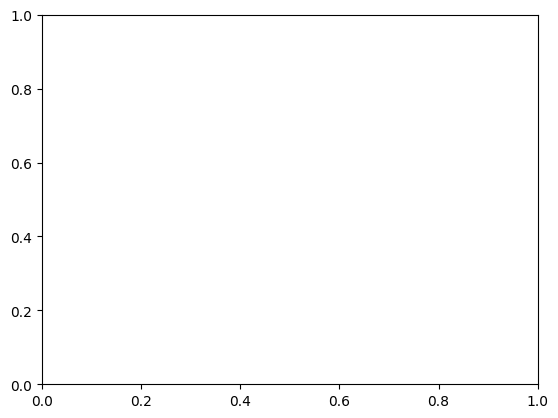

In [7]:
TRAIN_N   = 200_000
VAL_N     = 50_000
number_of_prev_t = num_of_prev_t #Also change in the preprocessing step up above
input_dim = 75
output_dim = 75
latent_dim = 1024
condition_dim = 75
batch_size = 1024
num_epochs = 50
prev_elem = 75 * number_of_prev_t

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim, prev_elem)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)



def roll_memory(memory_row: torch.Tensor, new_state: torch.Tensor, n_prev: int) -> torch.Tensor:
    """
    memory_row : (1, n_prev*75)  – flattened window [x(t‑n_prev), …, x(t‑1)]
    new_state  : (1, 75)         – x(t) just produced
    returns    : (1, n_prev*75)  – flattened window [x(t‑n_prev+1), …, x(t)]
    """
    # reshape → (1, n_prev, 75), drop the oldest slice, append new_state, flatten again
    mem_3d = memory_row.view(1, n_prev, 75)
    mem_new = torch.cat([mem_3d[:, 1:, :], new_state.unsqueeze(1)], dim=1)
    return mem_new.reshape(1, -1)

for epoch in range(num_epochs):
    model.train()
    for batch in range (0, TRAIN_N, batch_size):

        ### Changed here to include the previous element in batching samples
        prev_element = psi_memory[batch:batch + batch_size,:]

        input_batch = psi_train_input[batch:batch + batch_size,:]
        label_batch = psi_train_label[batch:batch + batch_size,:]
        optimizer.zero_grad()


        ### Changed here to pass the previous element to the Decoder to reconstruct using the previous states  ###
        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda(), prev_element.float().cuda())

        # Reconstruction loss
        reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
        # KL divergence loss
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        
        # Total loss
        loss = reconstruction_loss + 10 * kl_loss

        loss.backward()
        optimizer.step()

    print(f'''Epoch {epoch+1}, 
          Reconstrunction Loss: {reconstruction_loss},
          KL Divergence Lwss: {kl_loss}''')

    # # Validation Loss
    # for batch in range (0, VAL_N, batch_size):
        
    #     ### Same as before but for the validiation set ###
    #     prev_element = psi_memory_val[batch:batch + batch_size,:]

    #     input_batch = psi_val_input[batch:batch + batch_size,:]
    #     label_batch = psi_val_label[batch:batch + batch_size,:]
        
    #     ### Same as before but for the validation set ### 
    #     output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda(), prev_element.float().cuda())
    #     reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
    #     kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
    #     val_loss = reconstruction_loss + 10 * kl_loss # Experiment HIGHER coefficients
    #     # Print both reconstruction_loss and kl_loss

    # print(f'''
    #       Validation Reconstrunction Loss: {reconstruction_loss},
    #       Validation KL Divergence Loss: {kl_loss}''')

    # Inference

    ### Changed here to use the x(t) and x(t - 1) as ground truth elements
    initial_cond = torch.reshape(torch.tensor(psi[1,:]), [1, 75])
    t0 = num_of_prev_t

    psi_torch = torch.as_tensor(psi, dtype=torch.float32)

    # ----- build initial condition -------------------------------------------
    # current state x(t)
    initial_cond = psi_torch[t0].unsqueeze(0)            

    # sliding window of x(t‑1) … x(t‑num_of_prev_t)
    history = psi_torch[t0 - num_of_prev_t : t0]              
    history_flat = history.reshape(1, -1)
    preveious_elem = history_flat
    time_step = 30000
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros ([time_step, 75, num_ens])

    for k in range (0, time_step):
        for ens in range (0, num_ens):
            if (k ==0):
                z = torch.randn_like(z)
                y = (model.decode(z.float().cuda(), initial_cond.float().cuda(), preveious_elem.float().cuda())).detach().cpu().numpy()
                pred[k,:,ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                new_state = torch.tensor((y_denorm - mean_psi)/ std_psi)
                preveious_elem = roll_memory(preveious_elem, new_state, num_of_prev_t)
                initial_cond = new_state
    
            else:
                select_ens = np.random.randint(0,num_ens,1)
                z = torch.randn_like(z)
                input_element = torch.reshape(torch.tensor(pred[k-1,:,select_ens]), [1,75]).float().cuda()
                y = (model.decode(z.float().cuda(), input_element, preveious_elem.float().cuda())).detach().cpu().numpy()
                pred[k,:, ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                new_state = torch.tensor((y_denorm - mean_psi) / std_psi)
                preveious_elem = roll_memory(preveious_elem, new_state, num_of_prev_t)
                initial_cond = new_state


    # Denormalize final preds
    print(std_psi[:, 63])
    pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

    # Denormalize test labels
    actual_values = psi_train_label[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
    print(actual_values)

    plt.plot(pred_mean[0:30000,63],'r')
    plt.title(f"Predictions vs Actual | Batch size of {batch_size}")
    plt.show()
    plt.cla()